# The MEL Scale

### AUDITORY FREQUENCY SCALES
The MEL scale was originally (1940's) derived as a scale for pitch (melody).
These days it is used as a generic "auditory" frequency scale.

The general line of thinking goes as follows: perceptual interference of signals is strong if they have close or overlapping frequencies, on the other hand perceptual interference is minimal or non existent if their frequency ranges are somewhat apart. On the auditory frequency scale frequencies need to be at least 1 unit (mel) apart to have no interference. 

Such auditory frequency scales may thus be derived by a variety of perceptual experiments, including pitch ranking, loudness summation and simultaneous masking effects.   Depending on the studied effect, the derived scale will be slightly different and have a variety of names such as the **MEL** scale, **BARK** scale, the **ERB** scale, **1/3th octave filterbanks**, ...

Maybe the easiest to understand property is that the loudness of a speech signal is well approximated by following approach:  
1. divide the speech range into 24 mel bands 
2. measure intensity in each band and do a frequency dependent intensity to loudness mapping
3. add the loudness of all bands together and you get an estimate of total loudness

 
Putting small differences aside, all these scales are very similar and very much in line with our understanding of the physiological system. The principles can be summarized as:
- linear scaling up to 1kHz
- logarithmic above 1kHz

The two most popular conversions between Hz and mel are:
1. Approximation by D. O'Shaughnessy which is also used in HTK, Kaldi and TorchAudio :       

$$
mel(f) = 11.27 \times \log \left( 1 + \frac{f}{700} \right)      
$$
and
$$
f(mel) = 700.0 \times \left( \exp \left( \frac{mel}{11.27} \right) -1  \right)
$$

2. The approximation in librosa adopted from M. Slaney's MATLAB Auditory Toolbox is a linear mapping up to 1kHz and logarithmic above, with following formula (for frequencies above 1kHz)

$$
mel(f) = 15 + \frac{ log\left( f/1000 \right) }{mstep}
$$
and
$$
f(mel) = 1000.0 \times exp\left( mstep \times( mel - 15) \right) 
$$
with
$$
mstep = log(6.4)/27   
$$

Notes:
1. Scaling of 'mel' is arbitrary.  The above two scales were originally developed for the indexing of filterbanks. If we want to compare both scales, easiest is to divide the Slaney scale by a factor of 1.5 such that they both align at  mel(f=1000)=10.  This is taken as the anchor point between almost linear mapping for lower frequencies and almost logarithmic mapping for higher frequencies.
2. Other implementations (eg. David-Mermelstein) have essentially the same functionality.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
import librosa

In [2]:
# convert frequency in Hz to MEL
def f2mel(f,scale='LIBROSA'):
    if scale == 'OS':
        return( 11.27 * np.log(1+f/700) )
    elif scale == 'LIBROSA':
        return( librosa.hz_to_mel(f,htk=False) )
    elif scale == 'DM':
        m = np.array(f)
        for i in range(len(f)):
             m[i] = f[i]/100. if (f[i] <= 1000.) else  10. + 5.*np.log2(f[i]/1000.)
        return(m)
    
# convert MEL to frequency in Hz
def mel2f(mel,scale='LIBROSA'):
    if scale == 'OS':
        return( 700. * (np.exp(mel/11.27) - 1.))
    elif scale == 'LIBROSA':
        return( librosa.mel_to_hz(mel ,htk=False) )  
    elif scale == 'DM':
        f = np.array(mel)
        for i in range(len(mel)):
             f[i] = mel[i]*100. if (mel[i] <= 10.) else  1000.*np.power(2.,(mel[i]-10.)/5.)
        return(f)

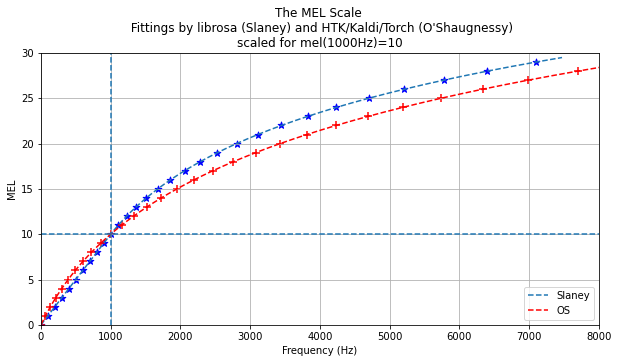

In [3]:
mels = np.arange(0.,30.,.5)
freqs = mel2f(1.5*mels)
freqs_os = mel2f(mels,scale='OS')
freqs_dm = mel2f(mels,scale='DM')


fig,ax1 = plt.subplots()
ax1.plot(freqs,mels,'--')
ax1.scatter(freqs[::2],mels[::2],marker='*',color='b',s=50)
ax1.plot(freqs_os,mels,'--',color='r')
ax1.scatter(freqs_os[::2],mels[::2],marker='+',color='r',s=50)
#ax1.plot(freqs_dm,mels,'--',color='g')
#ax1.scatter(freqs_dm[::2],mels[::2],marker='*',color='g',s=50)
ax1.grid()
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel("MEL")
#ax1.tick_params(axis='y')
ax1.set_title('The MEL Scale \n Fittings by librosa (Slaney) and HTK/Kaldi/Torch (O\'Shaugnessy)\nscaled for mel(1000Hz)=10');
ax1.set_ylim([0.,30.])
ax1.set_xlim([0,8000])
ax1.axvline(1000,linestyle='dashed')
ax1.axhline(10,linestyle='dashed')
ax1.legend(['Slaney','OS']);

### MEL FILTERBANK

A mel filterbank is a practical tool to do the mapping of a Fourier spectrum to a mel spectrum.
Each filter measures the energy in a small frequency range.  By having a set of filters with center frequencies equally spaced on the mel scale we have an effective way to do this transform.   The filtering itself is done by adding up the powers of Fourier spectral coefficients within a band, weighted for the filter characteristic.

There are two aspects to the filterbank design:
1. find the centerfrequencies, equally spaced on the mel scale
2. map a basic filter shape onto each centerfrequency


Further Notes:
- You need to take into account that all filters will have a certain width; in the design function below you can either specify the frequency range of the center frequencies or specify the full range up to the edges of the bands  
- It is also well known that the data at the fringes of the frequency range is not be very reliable. This is due to the necessary though hardware dependent DC filtering and anti-aliasing filtering.  Therefore it is common practice to throw away one or several of the lowest and highest bands in speech recognition systems.



In [4]:
def melfbank(nb,low_f,high_f,Center=True):
    '''
    nb: number of bands
    low_f and high_f: frequency range in Hz
        if Center: low_f and high_f are low and high center frequencies for first and last band
             else: low_f and high_f are low and high cutoff frequencies for first and last band
    
    returns: 
        array of center frequencies (in Hz)
    '''

    m0 = f2mel(low_f)
    m1 = f2mel(high_f)
    if Center is False:
        delta_m = (m1-m0)/(nb+1.)
        m0 = m0+delta_m
        m1 = m1-delta_m
    else:
        delta_m = (m1-m0)/(nb-1.)
    mc = np.linspace(m0,m1,nb,endpoint=True)
    fc = mel2f(mc)
    return(fc)

def edges_from_cf(fc,width=None):
    '''
    width = None:  standard minimum overlap filters
    else with is specified in mel
    '''
    mc = f2mel(fc)
    if width is None:
        width = mc[1]-mc[0]
    lc = mel2f(mc - width)
    hc = mel2f(mc + width)
    return(lc,hc)

def plot_fbank(cf):
    (lc,hc) = edges_from_cf(cf)
    nb = len(cf)
    for i in range(nb):
        plt.plot([lc[i],cf[i]],[0,1])
        plt.plot([hc[i],cf[i]],[0,1])
    plt.grid()
    plt.xlim(0.,6000)
    plt.ylim(0,1.1)
    plt.xlabel('Frequency (Hz)')
    plt.title("%d channel MEL FILTERBANK" % nb);

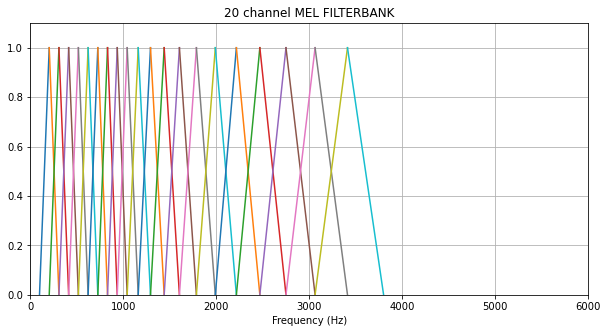

In [5]:
# 20 channel filterbank telephone range
cf20 = melfbank(20,100,3800,Center=False)
plot_fbank(cf20)

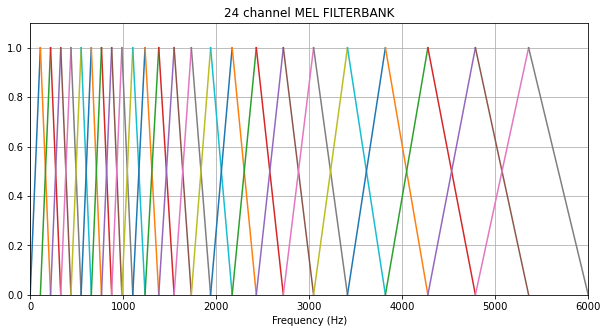

In [6]:
# 24 channel filterbank speech range
cf24 = melfbank(24,0,6000,Center=False)
plot_fbank(cf24)

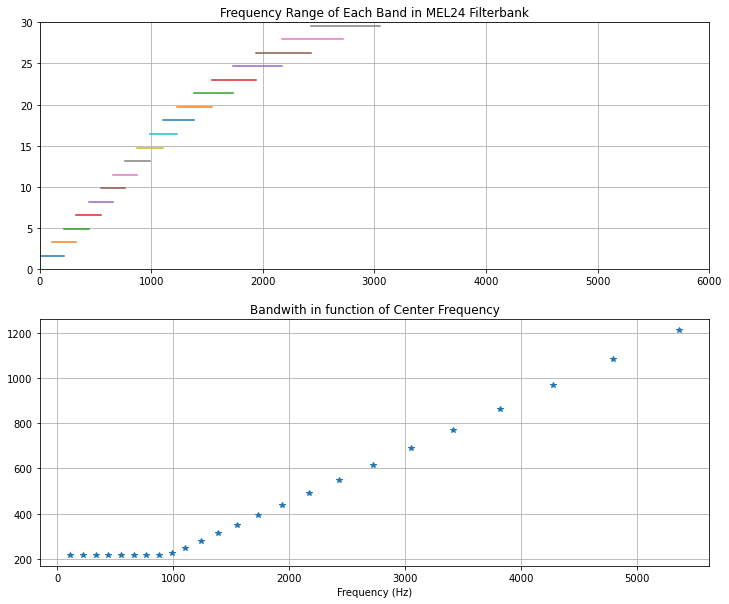

In [7]:
# alternative view for filterbank
cf=cf24
(lc,hc) = edges_from_cf(cf)
mc = f2mel(cf)
nb = len(cf)
fig, axx = plt.subplots(2,1,figsize=(12,10))

ax=axx[0]
for i in range(nb):
    ax.plot([lc[i],hc[i]],[mc[i],mc[i]])
    #plt.plot([hc[i],cf[i]],[0,1])
ax.grid()
ax.set_xlim(0.,6000)
ax.set_ylim(0,30.)

ax.set_title("Frequency Range of Each Band in MEL24 Filterbank");

ax=axx[1]
ax.plot(cf,hc-lc,'*')
ax.grid()
ax.set_xlabel('Frequency (Hz)')
ax.set_title("Bandwith in function of Center Frequency");


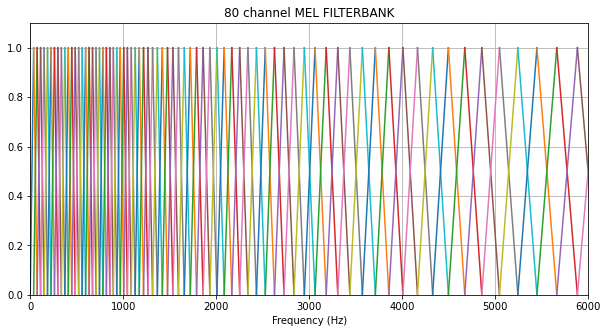

In [8]:
# 80 channel filterbank 0-8kHz
cf80 = melfbank(80,0,8000,Center=False)
plot_fbank(cf80)